In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [22]:
from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device("cuda")

In [24]:
class my_norm(object):
    def __init__(self, val=255):
        self.val = val

    def __call__(self, tensor):
        return tensor/val

    def __repr__(self):
        return self.__class__.__name__ + "normalizing value = {0}".format(self.val)
    
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [25]:
class FeatureCopy(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, image

In [26]:
#custom transformation

transform=Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., .5)
])

In [27]:
batch_size = 128

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,  
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor(),
)

In [28]:
#Data for de-noising

train_data = FeatureCopy(train_data)
test_data = FeatureCopy(test_data)

In [29]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator("cuda"))
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, generator=torch.Generator("cuda"))

In [30]:
# class Reshape(nn.Module):
#     def __init__(self, shape):
#         super(Reshape, self).__init__()
#         self.shape = shape
#     def forward(self, x):
#         return x.view(self.shape)

In [31]:
class AutoEncoder(nn.Module):
    def __init__(self, shape=None):
        super(AutoEncoder, self).__init__()
        self.shape = shape
        self.encoder = nn.Sequential(
            # nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(784, 256),
            # nn.ReLU(),
            # nn.Linear(256, 10),
            nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            # nn.Linear(10, 256),
            # nn.ReLU(),
            nn.Linear(256, 784),
            #Reshape(shape)
        )

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out


In [32]:
autoencoder = AutoEncoder()

In [33]:
shape = (64, 1, 28, 28)

In [34]:
from torch import optim

loss_func = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(autoencoder.parameters(), lr = 1e-3)

In [35]:
def train(num_epochs, model, loader):
   
    model.train()
    total_step = len(loader)
    for epoch in range(num_epochs):
        with torch.set_grad_enabled(True):
            for i, (images, labels) in enumerate(loader):
    
                x = Variable(images).to(device)   
                y = Variable(labels).to(device)
                
                output = model(x)             
                output = output.view(y.size())
                loss = loss_func(output, y)
                
                optimizer.zero_grad()           
                loss.backward()         
                optimizer.step()                
                
                if (i+1) % 100 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                           .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))


In [36]:
train(num_epochs=10, model=autoencoder, loader=train_dataloader)

Epoch [1/10], Step [100/469], Loss: 0.0379
Epoch [1/10], Step [200/469], Loss: 0.0243
Epoch [1/10], Step [300/469], Loss: 0.0177
Epoch [1/10], Step [400/469], Loss: 0.0143
Epoch [2/10], Step [100/469], Loss: 0.0109
Epoch [2/10], Step [200/469], Loss: 0.0090
Epoch [2/10], Step [300/469], Loss: 0.0078
Epoch [2/10], Step [400/469], Loss: 0.0070
Epoch [3/10], Step [100/469], Loss: 0.0066
Epoch [3/10], Step [200/469], Loss: 0.0059
Epoch [3/10], Step [300/469], Loss: 0.0056
Epoch [3/10], Step [400/469], Loss: 0.0052
Epoch [4/10], Step [100/469], Loss: 0.0045
Epoch [4/10], Step [200/469], Loss: 0.0044
Epoch [4/10], Step [300/469], Loss: 0.0042
Epoch [4/10], Step [400/469], Loss: 0.0040
Epoch [5/10], Step [100/469], Loss: 0.0038
Epoch [5/10], Step [200/469], Loss: 0.0035
Epoch [5/10], Step [300/469], Loss: 0.0036
Epoch [5/10], Step [400/469], Loss: 0.0035
Epoch [6/10], Step [100/469], Loss: 0.0032
Epoch [6/10], Step [200/469], Loss: 0.0029
Epoch [6/10], Step [300/469], Loss: 0.0031
Epoch [6/10

In [37]:
images, labels = next(iter(test_dataloader))
images, labels = images.to(device), labels.to(device)
real = labels[:10]

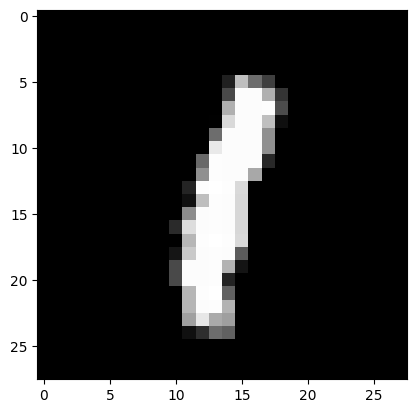

In [38]:
sample = (real[0].squeeze()).cpu().numpy()
plt.imshow(sample, cmap="gray")
plt.show()

In [39]:
autoencoder.eval()

pred = autoencoder(images[:10].to(device))
pred = pred.view(real.size())
sample_pred = pred[0].detach().cpu().numpy().squeeze()

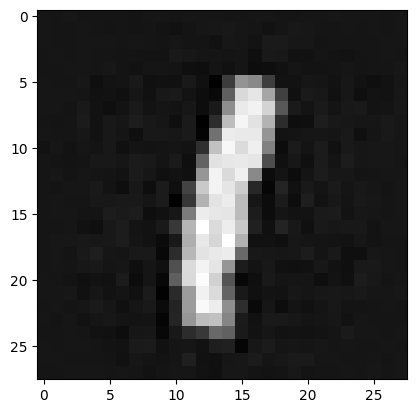

In [40]:
plt.imshow(sample_pred, cmap="gray")
plt.show()

In [41]:
class DecoderOnly(nn.Module):
    def __init__(self, autoencoder):
        super(DecoderOnly, self).__init__()
        self.decoder = autoencoder.decoder

    def forward(self, x):
        out = self.decoder(x)
        return out

In [67]:
decoder = DecoderOnly(autoencoder)
for param in decoder.parameters():
    param.data = param.data.double()
decoder = decoder.double()

In [68]:
test_inp = torch.rand(256, dtype=torch.float64, device=device)

In [71]:
test_out = decoder(test_inp)

In [73]:
test_out = test_out.view(1, 28, 28)
out_img = test_out[0].detach().cpu().numpy().squeeze()

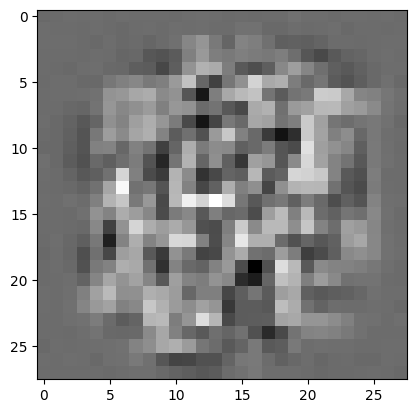

In [75]:
plt.imshow(out_img, cmap="gray")
plt.show()